In [3]:
# custom stitch for 3D data
import numpy as np
import pandas as pd


In [4]:
centroids_data = pd.read_csv('input\stitch\cp_masks_E3H5_Round1_DAPI_tile1_inference_centroids.csv')

In [5]:
centroids_data

,label,centroid-0,centroid-1,centroid-2,area
0,1,40.383033,84.005141,894.534704,389.0
1,2,40.228216,122.491701,907.354772,482.0
2,3,41.926078,116.018480,895.726899,487.0
3,4,42.717710,117.000000,920.169108,751.0
4,5,41.627586,95.955172,896.434483,290.0
...,...,...,...,...,...
45926,45927,825.892857,924.964286,69.142857,28.0
45927,45928,825.777778,929.666667,17.444444,27.0
45928,45929,825.647059,930.676471,112.000000,34.0
45929,45930,825.753247,959.025974,118.714286,77.0


In [6]:
centroids_data.describe()

,label,centroid-0,centroid-1,centroid-2,area
count,45931.000000,45931.000000,45931.000000,45931.000000,45931.000000
mean,22966.000000,505.588413,554.883397,450.497693,971.633973
std,13259.281944,173.226477,300.365668,280.046880,1268.323881
min,1.000000,40.228216,0.181818,0.127660,15.000000
25%,11483.500000,373.195672,289.939719,216.849554,244.000000
50%,22966.000000,500.152000,588.271845,417.341429,606.000000
75%,34448.500000,639.000000,820.791529,668.639851,1248.000000
max,45931.000000,826.000000,1022.843750,1023.000000,34639.000000


In [7]:
import pandas as pd
import numpy as np

# 1. Setup data structure
class Region:
   def __init__(self, vertex, width=1024):
       self.vertex = vertex  # (x,y,z)
       self.width = width
       self.points_df = None  # Will store points DataFrame
       
   def get_boundaries(self):
       return {
           'x_min': self.vertex[0],
           'x_max': self.vertex[0] + self.width,
           'y_min': self.vertex[1], 
           'y_max': self.vertex[1] + self.width
       }

def find_overlaps(regions):
   n_regions = len(regions)
   overlaps = []
   
   for i in range(n_regions):
       for j in range(i+1, n_regions):
           r1 = regions[i].get_boundaries()
           r2 = regions[j].get_boundaries()
           
           # Check overlap
           if (r1['x_max'] > r2['x_min'] and r1['x_min'] < r2['x_max'] and
               r1['y_max'] > r2['y_min'] and r1['y_min'] < r2['y_max']):
               
               overlap = {
                   'regions': (i,j),
                   'x_min': max(r1['x_min'], r2['x_min']),
                   'x_max': min(r1['x_max'], r2['x_max']),
                   'y_min': max(r1['y_min'], r2['y_min']),
                   'y_max': min(r1['y_max'], r2['y_max'])
               }
               overlaps.append(overlap)
               print(f"Overlap found between regions {i} and {j}")
               print(f"Overlap area: {overlap}")
               
   return overlaps

def get_reference_lines(overlaps):
   ref_lines = []
   for overlap in overlaps:
       mid_x = (overlap['x_min'] + overlap['x_max']) / 2
       ref_lines.append({
           'x': mid_x,
           'regions': overlap['regions']
       })
       print(f"Reference line at x={mid_x} for regions {overlap['regions']}")
   return ref_lines

def map_points(regions, ref_lines):
   final_points = []
   
   for i, region in enumerate(regions):
       df = region.points_df
       if df is None:
           continue
           
       # Add region offset
       mapped_df = df.copy()
       mapped_df['global_x'] = df['x'] + region.vertex[0]
       mapped_df['global_y'] = df['y'] + region.vertex[1]
       mapped_df['global_z'] = df['z'] + region.vertex[2]
       mapped_df['region'] = i
       
       # Check reference lines
       for line in ref_lines:
           if i in line['regions']:
               other_region = line['regions'][0] if line['regions'][1] == i else line['regions'][1]
               # Keep points on correct side of reference line
               if i < other_region:
                   mapped_df = mapped_df[mapped_df['global_x'] <= line['x']]
               else:
                   mapped_df = mapped_df[mapped_df['global_x'] > line['x']]
                   
       final_points.append(mapped_df)
       print(f"Region {i}: {len(mapped_df)} points after filtering")
       
   return pd.concat(final_points, ignore_index=True)


In [9]:
import pandas as pd
import glob
import os

def load_centroid_files(input_dir):
   centroids_by_region = {}
   
   # Get all centroid CSV files
   files = glob.glob(os.path.join(input_dir, '*centroids.csv'))
   print(f"Found {len(files)} centroid files")
   
   for file in files:
       # Extract region number from filename 
       region = int(file.split('tile')[1][0])
       df = pd.read_csv(file)
       centroids_by_region[region] = df
       print(f"Region {region}: loaded {len(df)} points")
       
   return centroids_by_region

# Usage
centroids_dict = load_centroid_files('input/stitch/')

Found 6 centroid files
Region 1: loaded 45931 points
Region 2: loaded 21673 points
Region 3: loaded 26754 points
Region 4: loaded 42789 points
Region 5: loaded 32396 points
Region 6: loaded 12475 points


In [12]:
def load_centroid_files(input_dir):
   centroids_by_region = {}
   files = glob.glob(os.path.join(input_dir, '*centroids.csv'))
   print(f"Found {len(files)} centroid files")
   
   for file in files:
       region = int(file.split('tile')[1][0])  
       df = pd.read_csv(file)
       # Rename columns to x,y,z
       df = df.rename(columns={
           'centroid-0': 'z',
           'centroid-1': 'x', 
           'centroid-2': 'y'
       })
       centroids_by_region[region] = df
       print(f"Region {region}: {len(df)} points, x range: {df['x'].min():.1f}-{df['x'].max():.1f}, y range: {df['y'].min():.1f}-{df['y'].max():.1f}")
   
   return centroids_by_region

# Rest of code remains same
vertices = [
  (0, 0, 0),
  (921, 0, 0),
  (921, 921, 0),
  (0, 921, 0),
  (0, 1842, 0),
  (921, 1842, 0),
]

regions = [Region(vertex) for vertex in vertices]
centroids_dict = load_centroid_files('input/stitch/')
for region_num, df in centroids_dict.items():
   regions[region_num-1].points_df = df[['x','y','z']]  # Select only coordinate columns

overlaps = find_overlaps(regions)
ref_lines = get_reference_lines(overlaps)
final_df = map_points(regions, ref_lines)

Found 6 centroid files
Region 1: 45931 points, x range: 0.2-1022.8, y range: 0.1-1023.0
Region 2: 21673 points, x range: 0.5-1022.8, y range: 0.2-794.9
Region 3: 26754 points, x range: 0.1-1022.7, y range: 0.2-838.5
Region 4: 42789 points, x range: 0.0-1022.6, y range: 0.1-1023.0
Region 5: 32396 points, x range: 0.3-1022.2, y range: 0.2-1022.8
Region 6: 12475 points, x range: 0.2-1021.9, y range: 0.0-737.0
Overlap found between regions 0 and 1
Overlap area: {'regions': (0, 1), 'x_min': 921, 'x_max': 1024, 'y_min': 0, 'y_max': 1024}
Overlap found between regions 0 and 2
Overlap area: {'regions': (0, 2), 'x_min': 921, 'x_max': 1024, 'y_min': 921, 'y_max': 1024}
Overlap found between regions 0 and 3
Overlap area: {'regions': (0, 3), 'x_min': 0, 'x_max': 1024, 'y_min': 921, 'y_max': 1024}
Overlap found between regions 1 and 2
Overlap area: {'regions': (1, 2), 'x_min': 921, 'x_max': 1945, 'y_min': 921, 'y_max': 1024}
Overlap found between regions 1 and 3
Overlap area: {'regions': (1, 3), 'x

In [13]:
def find_overlaps(regions):
    overlaps = []
    # Define grid positions (row, col) for each region
    grid_positions = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]
    
    for i in range(len(regions)):
        row_i, col_i = grid_positions[i]
        
        # Check horizontal overlaps (same row)
        if col_i == 0:  # Left column
            j = i + 1  # Right neighbor
            r1, r2 = regions[i].get_boundaries(), regions[j].get_boundaries()
            overlaps.append({
                'regions': (i,j),
                'x_min': r2['x_min'],
                'x_max': r1['x_max'],
                'y_min': max(r1['y_min'], r2['y_min']),
                'y_max': min(r1['y_max'], r2['y_max'])
            })
            
        # Check vertical overlaps (same column)
        if row_i < 2:  # Not bottom row
            j = i + 2  # Bottom neighbor
            r1, r2 = regions[i].get_boundaries(), regions[j].get_boundaries()
            overlaps.append({
                'regions': (i,j),
                'x_min': max(r1['x_min'], r2['x_min']),
                'x_max': min(r1['x_max'], r2['x_max']),
                'y_min': r2['y_min'],
                'y_max': r1['y_max']
            })
            
    return overlaps

In [15]:
def map_points(regions, ref_lines):
   final_points = []
   mid_x = (vertices[0][0] + vertices[1][0])/2 + vertices[1][0]  # Calculate middle point using vertex x coordinates
   
   for i, region in enumerate(regions):
       if region.points_df is None:
           continue
           
       mapped_df = df.copy()
       mapped_df['global_x'] = df['x'] + region.vertex[0]
       mapped_df['global_y'] = df['y'] + region.vertex[1]
       mapped_df['global_z'] = df['z'] + region.vertex[2]
       mapped_df['region'] = i
       
       col = i % 2
       if col == 0:
           mapped_df = mapped_df[mapped_df['global_x'] <= mid_x]
       else:
           mapped_df = mapped_df[mapped_df['global_x'] > mid_x]
           
       final_points.append(mapped_df)
       print(f"Region {i}: {len(mapped_df)} points, reference x: {mid_x}")
       
   return pd.concat(final_points, ignore_index=True)

In [16]:
def load_centroid_files(input_dir):
   centroids_by_region = {}
   files = glob.glob(os.path.join(input_dir, '*centroids.csv'))
   print(f"Found {len(files)} centroid files")
   
   for file in files:
       region = int(file.split('tile')[1][0])  
       df = pd.read_csv(file)
       # Rename columns to x,y,z
       df = df.rename(columns={
           'centroid-0': 'z',
           'centroid-1': 'x', 
           'centroid-2': 'y'
       })
       centroids_by_region[region] = df
       print(f"Region {region}: {len(df)} points, x range: {df['x'].min():.1f}-{df['x'].max():.1f}, y range: {df['y'].min():.1f}-{df['y'].max():.1f}")
   
   return centroids_by_region


In [26]:
overlaps

{'x_ref': 1381.5, 'y_refs': [1381.5, 2302.5]}

In [39]:
from dataclasses import dataclass
from dataclasses import dataclass
from typing import List, Tuple, Set

@dataclass
class box:
    x1: int  # top-left x
    y1: int  # top-left y
    z1: int  # top-left z
    x2: int  # bottom-right x
    y2: int  # bottom-right y
    z2: int  # bottom-right z


def create_rectangles(vertices: List[Tuple[int, int, int]], size: int) -> List[box]:
    """Create Rectangle objects from vertices and size"""
    boxes = []
    for vertex in vertices:
        x1, y1, z1 = vertex
        boxes.append(box(x1, y1, z1, x1 + size, y1 + size, z1 + size))
    return boxes

def get_overlap(rect1: box, rect2: box) -> box:
    """Calculate overlap between two boxes"""
    x1 = max(rect1.x1, rect2.x1)
    y1 = max(rect1.y1, rect2.y1)
    z1 = min(rect1.z1, rect2.z1)
    x2 = min(rect1.x2, rect2.x2)
    y2 = min(rect1.y2, rect2.y2)
    z2 = min(rect1.z2, rect2.y2)

    
    if x1 < x2 and y1 < y2 and z1 < z2:
        return box(x1, y1, z1, x2, y2, z2)
    return None

def calculate_area(rect: box) -> int:
    """Calculate area of a box"""
    return (rect.x2 - rect.x1) * (rect.y2 - rect.y1) * (rect.z2 - rect.z1)

def analyze_rectangles(vertices: List[Tuple[int, int, int]], size: int = 1024):
    """Analyze rectangles' boundaries and overlaps"""
    # Create rectangles
    rectangles = create_rectangles(vertices, size)
    
    # Calculate individual boundaries
    print("Individual Rectangle Boundaries:")
    for i, rect in enumerate(rectangles):
        print(f"Rectangle {i+1}: ({rect.x1}, {rect.y1}, {rect.z1}) to ({rect.x2}, {rect.y2}, {rect.z2})")
        print(f"Area: {calculate_area(rect)}")
    
    # Calculate overlaps
    print("\nOverlapping Regions:")
    for i in range(len(rectangles)):
        for j in range(i + 1, len(rectangles)):
            overlap = get_overlap(rectangles[i], rectangles[j])
            if overlap:
                print(f"Overlap between Rectangle {i+1} and {j+1}:")
                print(f"Region: ({overlap.x1}, {overlap.y1}, {overlap.z1}) to ({overlap.x2}, {overlap.y2}, {overlap.z2})")
                print(f"Overlap Area: {calculate_area(overlap)}")

# Example usage
# vertices = [
#     (0, 0, 0),
#     (921, 0, 0),
#     (921, 921, 0),
#     (0, 921, 0),
#     (0, 1842, 0),
#     (921, 1842, 0),
# ]

vertices = [
    (0.00, 0.00, 0.00),      # tile1
    (913.27, 5.24, 0.00),    # tile2
    (902.49, 920.44, 1.66),  # tile3
    (-16.66, 917.27, 2.32),  # tile4
    (-29.58, 1837.83, 3.75), # tile5
    (883.43, 1845.85, 5.24)  # tile6
]

# ZOFFSET = 826
analyze_rectangles(vertices)

Individual Rectangle Boundaries:
Rectangle 1: (0.0, 0.0, 0.0) to (1024.0, 1024.0, 1024.0)
Area: 1073741824.0
Rectangle 2: (913.27, 5.24, 0.0) to (1937.27, 1029.24, 1024.0)
Area: 1073741824.0
Rectangle 3: (902.49, 920.44, 1.66) to (1926.49, 1944.44, 1025.66)
Area: 1073741824.0
Rectangle 4: (-16.66, 917.27, 2.32) to (1007.34, 1941.27, 1026.32)
Area: 1073741823.9999999
Rectangle 5: (-29.58, 1837.83, 3.75) to (994.42, 2861.83, 1027.75)
Area: 1073741824.0
Rectangle 6: (883.43, 1845.85, 5.24) to (1907.4299999999998, 2869.85, 1029.24)
Area: 1073741823.9999999

Overlapping Regions:
Overlap between Rectangle 1 and 2:
Region: (913.27, 5.24, 0.0) to (1024.0, 1024.0, 1024.0)
Overlap Area: 115514669.87520002
Overlap between Rectangle 1 and 3:
Region: (902.49, 920.44, 0.0) to (1024.0, 1024.0, 1024.0)
Overlap Area: 12885581.414399993
Overlap between Rectangle 1 and 4:
Region: (0.0, 917.27, 0.0) to (1007.34, 1024.0, 1024.0)
Overlap Area: 110093719.75680003
Overlap between Rectangle 2 and 3:
Region: (9

In [40]:
from dataclasses import dataclass
from typing import List, Tuple, Set
import pandas as pd

@dataclass
class box:
    x1: float  # top-left x
    y1: float  # top-left y
    z1: float  # top-left z
    x2: float  # bottom-right x
    y2: float  # bottom-right y
    z2: float  # bottom-right z

def create_rectangles(vertices: List[Tuple[float, float, float]], size: float) -> List[box]:
    """Create Rectangle objects from vertices and size"""
    boxes = []
    for vertex in vertices:
        x1, y1, z1 = vertex
        boxes.append(box(x1, y1, z1, x1 + size, y1 + size, z1 + size))
    return boxes

def get_overlap(rect1: box, rect2: box) -> box:
    """Calculate overlap between two boxes"""
    x1 = max(rect1.x1, rect2.x1)
    y1 = max(rect1.y1, rect2.y1)
    z1 = min(rect1.z1, rect2.z1)
    x2 = min(rect1.x2, rect2.x2)
    y2 = min(rect1.y2, rect2.y2)
    z2 = min(rect1.z2, rect2.y2)
    
    if x1 < x2 and y1 < y2 and z1 < z2:
        return box(x1, y1, z1, x2, y2, z2)
    return None

def calculate_area(rect: box) -> float:
    """Calculate area of a box"""
    return (rect.x2 - rect.x1) * (rect.y2 - rect.y1) * (rect.z2 - rect.z1)

def analyze_rectangles(vertices: List[Tuple[float, float, float]], size: float = 1024):
    """Analyze rectangles' boundaries and overlaps"""
    # Create rectangles
    rectangles = create_rectangles(vertices, size)
    
    # Calculate individual boundaries
    boundaries_data = []
    for i, rect in enumerate(rectangles):
        boundaries_data.append({
            'Rectangle': f'Rectangle {i+1}',
            'Start_Point': f'({rect.x1:.2f}, {rect.y1:.2f}, {rect.z1:.2f})',
            'End_Point': f'({rect.x2:.2f}, {rect.y2:.2f}, {rect.z2:.2f})',
            'Area': f'{calculate_area(rect):.2f}'
        })
    
    boundaries_df = pd.DataFrame(boundaries_data)
    print("\nIndividual Rectangle Boundaries:")
    print(boundaries_df.to_string(index=False))
    
    # Calculate overlaps
    overlaps_data = []
    for i in range(len(rectangles)):
        for j in range(i + 1, len(rectangles)):
            overlap = get_overlap(rectangles[i], rectangles[j])
            if overlap:
                overlaps_data.append({
                    'Rectangles': f'Rectangle {i+1} & {j+1}',
                    'Start_Point': f'({overlap.x1:.2f}, {overlap.y1:.2f}, {overlap.z1:.2f})',
                    'End_Point': f'({overlap.x2:.2f}, {overlap.y2:.2f}, {overlap.z2:.2f})',
                    'Overlap_Area': f'{calculate_area(overlap):.2f}'
                })
    
    if overlaps_data:
        overlaps_df = pd.DataFrame(overlaps_data)
        print("\nOverlapping Regions:")
        print(overlaps_df.to_string(index=False))
    else:
        print("\nNo overlapping regions found.")

# Example usage
vertices = [
    (0.00, 0.00, 0.00),      # tile1
    (913.27, 5.24, 0.00),    # tile2
    (902.49, 920.44, 1.66),  # tile3
    (-16.66, 917.27, 2.32),  # tile4
    (-29.58, 1837.83, 3.75), # tile5
    (883.43, 1845.85, 5.24)  # tile6
]

analyze_rectangles(vertices)


Individual Rectangle Boundaries:
  Rectangle             Start_Point                   End_Point          Area
Rectangle 1      (0.00, 0.00, 0.00) (1024.00, 1024.00, 1024.00) 1073741824.00
Rectangle 2    (913.27, 5.24, 0.00) (1937.27, 1029.24, 1024.00) 1073741824.00
Rectangle 3  (902.49, 920.44, 1.66) (1926.49, 1944.44, 1025.66) 1073741824.00
Rectangle 4  (-16.66, 917.27, 2.32) (1007.34, 1941.27, 1026.32) 1073741824.00
Rectangle 5 (-29.58, 1837.83, 3.75)  (994.42, 2861.83, 1027.75) 1073741824.00
Rectangle 6 (883.43, 1845.85, 5.24) (1907.43, 2869.85, 1029.24) 1073741824.00

Overlapping Regions:
     Rectangles             Start_Point                   End_Point Overlap_Area
Rectangle 1 & 2    (913.27, 5.24, 0.00) (1024.00, 1024.00, 1024.00) 115514669.88
Rectangle 1 & 3  (902.49, 920.44, 0.00) (1024.00, 1024.00, 1024.00)  12885581.41
Rectangle 1 & 4    (0.00, 917.27, 0.00) (1007.34, 1024.00, 1024.00) 110093719.76
Rectangle 2 & 3  (913.27, 920.44, 0.00) (1926.49, 1029.24, 1024.00) 112884

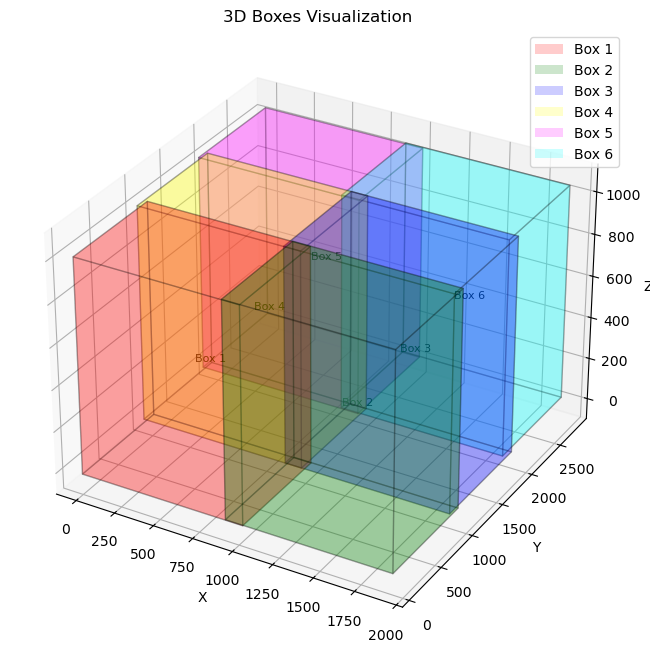

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def create_box_vertices(start_point, end_point):
    x0, y0, z0 = start_point
    x1, y1, z1 = end_point
    
    vertices = np.array([
        [x0, y0, z0], [x1, y0, z0], [x1, y1, z0], [x0, y1, z0],
        [x0, y0, z1], [x1, y0, z1], [x1, y1, z1], [x0, y1, z1]
    ])
    
    return vertices

def create_box_faces(vertices):
    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],  # bottom
        [vertices[4], vertices[5], vertices[6], vertices[7]],  # top
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # front
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # back
        [vertices[0], vertices[3], vertices[7], vertices[4]],  # left
        [vertices[1], vertices[2], vertices[6], vertices[5]]   # right
    ]
    return faces

# Define the boxes
boxes = [
    ((0.00, 0.00, 0.00), (1024.00, 1024.00, 1024.00)),
    ((913.27, 5.24, 0.00), (1937.27, 1029.24, 1024.00)),
    ((902.49, 920.44, 1.66), (1926.49, 1944.44, 1025.66)),
    ((-16.66, 917.27, 2.32), (1007.34, 1941.27, 1026.32)),
    ((-29.58, 1837.83, 3.75), (994.42, 2861.83, 1027.75)),
    ((883.43, 1845.85, 5.24), (1907.43, 2869.85, 1029.24))
]

# Colors for each box
colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan']
alphas = [0.2] * 6  # Transparency for each box

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each box
for i, ((start, end), color) in enumerate(zip(boxes, colors)):
    vertices = create_box_vertices(start, end)
    faces = create_box_faces(vertices)
    
    # Create the 3D collection
    poly3d = Poly3DCollection(faces, alpha=alphas[i])
    poly3d.set_facecolor(color)
    poly3d.set_edgecolor('black')
    
    # Add the collection to the plot
    ax.add_collection3d(poly3d)
    
    # Add text label at the center of the box
    center = np.mean([start, end], axis=0)
    ax.text(center[0], center[1], center[2], f'Box {i+1}', fontsize=8)

# Set the plot limits
all_points = np.array([start + end for start, end in boxes]).reshape(-1, 3)
min_vals = all_points.min(axis=0)
max_vals = all_points.max(axis=0)
margin = 100  # Add some margin

ax.set_xlim(min_vals[0] - margin, max_vals[0] + margin)
ax.set_ylim(min_vals[1] - margin, max_vals[1] + margin)
ax.set_zlim(min_vals[2] - margin, max_vals[2] + margin)

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Boxes Visualization')

# Add a legend
legend_elements = [plt.Rectangle((0,0), 1, 1, fc=color, alpha=0.2) for color in colors]
ax.legend(legend_elements, [f'Box {i+1}' for i in range(len(boxes))], 
         loc='upper right')

# Show the plot
plt.show()

View: front - Intersection between Box 1 and Box 2 at: (1024.00, 5.24, 5.24)
View: front - Intersection between Box 1 and Box 2 at: (913.27, 1024.00, 1024.00)
View: front - Intersection between Box 1 and Box 3 at: (1024.00, 920.44, 920.44)
View: front - Intersection between Box 1 and Box 3 at: (902.49, 1024.00, 1024.00)
View: front - Intersection between Box 1 and Box 4 at: (1007.34, 1024.00, 1024.00)
View: front - Intersection between Box 1 and Box 4 at: (0.00, 917.27, 917.27)
View: front - Intersection between Box 2 and Box 3 at: (1926.49, 1029.24, 1024.00)
View: front - Intersection between Box 2 and Box 3 at: (913.27, 920.44, 915.20)
View: front - Intersection between Box 2 and Box 4 at: (1007.34, 1029.24, 1024.00)
View: front - Intersection between Box 2 and Box 4 at: (913.27, 917.27, 912.03)
View: front - Intersection between Box 3 and Box 4 at: (1007.34, 920.44, 1.66)
View: front - Intersection between Box 3 and Box 4 at: (902.49, 1941.27, 1022.49)
View: front - Intersection bet

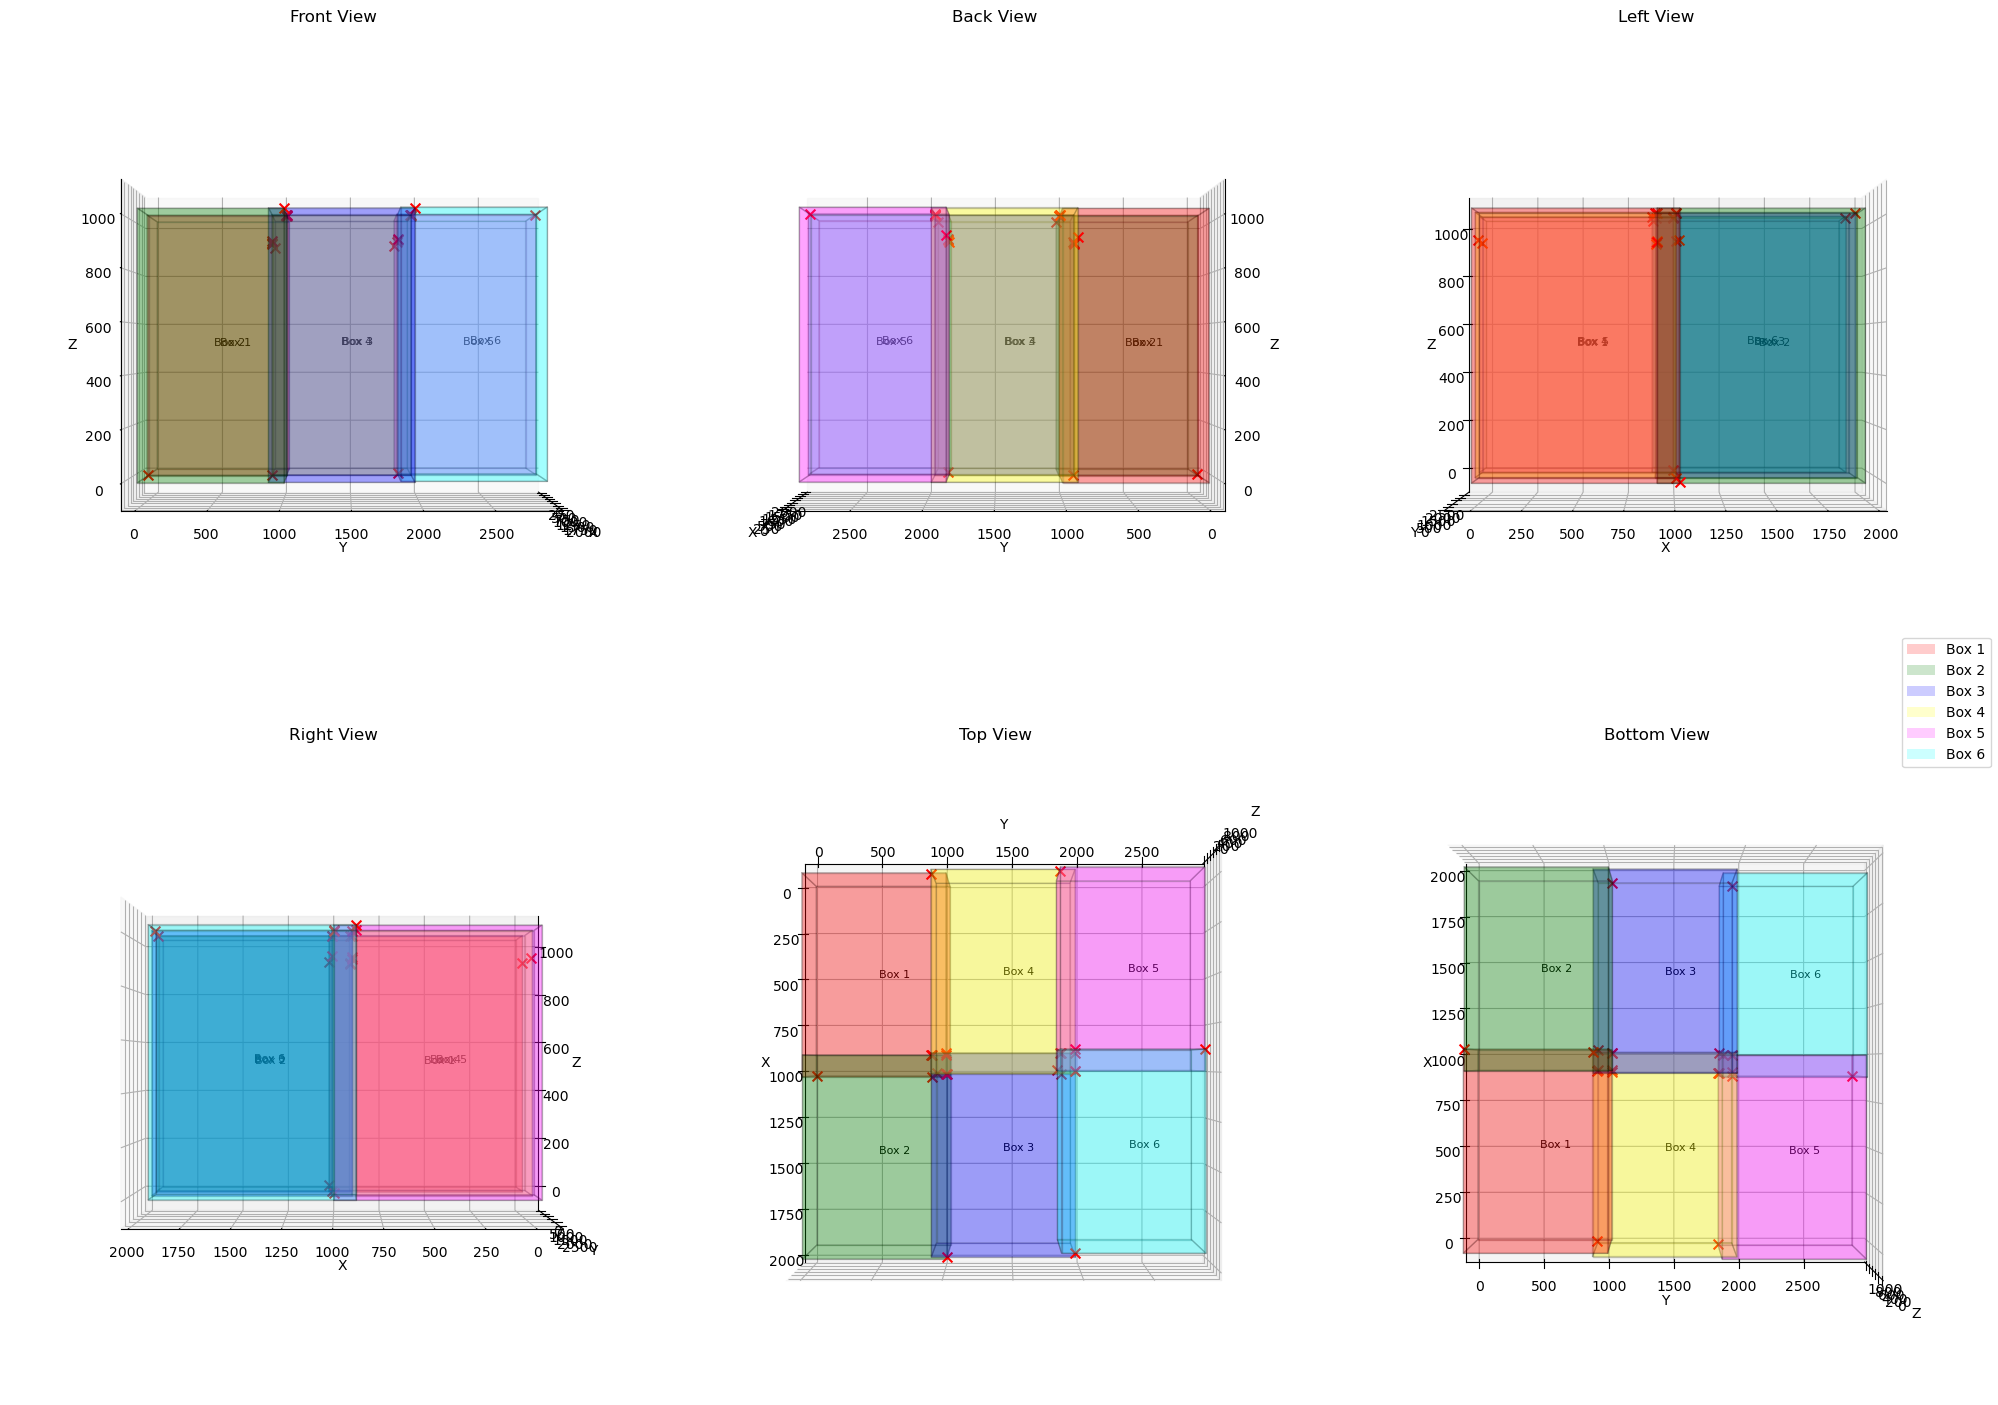

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def create_box_vertices(start_point, end_point):
    x0, y0, z0 = start_point
    x1, y1, z1 = end_point
    
    vertices = np.array([
        [x0, y0, z0], [x1, y0, z0], [x1, y1, z0], [x0, y1, z0],
        [x0, y0, z1], [x1, y0, z1], [x1, y1, z1], [x0, y1, z1]
    ])
    
    return vertices

def create_box_faces(vertices):
    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],  # bottom
        [vertices[4], vertices[5], vertices[6], vertices[7]],  # top
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # front
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # back
        [vertices[0], vertices[3], vertices[7], vertices[4]],  # left
        [vertices[1], vertices[2], vertices[6], vertices[5]]   # right
    ]
    return faces

def find_line_intersection(line1_start, line1_end, line2_start, line2_end):
    # Convert to numpy arrays for easier calculation
    p1, p2 = np.array(line1_start), np.array(line1_end)
    p3, p4 = np.array(line2_start), np.array(line2_end)
    
    # Calculate direction vectors
    v1 = p2 - p1
    v2 = p4 - p3
    
    # Calculate the cross product of direction vectors
    cross_v1_v2 = np.cross(v1[:2], v2[:2])  # Using only x,y components
    
    # If lines are parallel, return None
    if abs(cross_v1_v2) < 1e-10:
        return None
    
    # Calculate intersection parameter
    t = np.cross(p3[:2] - p1[:2], v2[:2]) / cross_v1_v2
    
    # Check if intersection point lies within both line segments
    if 0 <= t <= 1:
        u = np.cross(p3[:2] - p1[:2], v1[:2]) / cross_v1_v2
        if 0 <= u <= 1:
            # Calculate intersection point
            intersection = p1 + t * v1
            return intersection
    
    return None

def plot_boxes_view(ax, boxes, colors, alphas, view='front'):
    # Set the view angle based on the perspective
    views = {
        'front': (0, 0),    # azimuth, elevation
        'back': (180, 0),
        'left': (-90, 0),
        'right': (90, 0),
        'top': (0, 90),
        'bottom': (0, -90)
    }
    
    az, el = views[view]
    ax.view_init(elev=el, azim=az)
    
    # Plot boxes
    for i, ((start, end), color) in enumerate(zip(boxes, colors)):
        vertices = create_box_vertices(start, end)
        faces = create_box_faces(vertices)
        
        poly3d = Poly3DCollection(faces, alpha=alphas[i])
        poly3d.set_facecolor(color)
        poly3d.set_edgecolor('black')
        ax.add_collection3d(poly3d)
        
        # Add text label
        center = np.mean([start, end], axis=0)
        ax.text(center[0], center[1], center[2], f'Box {i+1}', fontsize=8)
    
    # Calculate and plot intersections
    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            box1_start, box1_end = boxes[i]
            box2_start, box2_end = boxes[j]
            
            # Get edges for each box
            edges1 = [
                (box1_start, (box1_end[0], box1_start[1], box1_start[2])),
                ((box1_end[0], box1_start[1], box1_start[2]), box1_end),
                (box1_end, (box1_start[0], box1_end[1], box1_end[2])),
                ((box1_start[0], box1_end[1], box1_end[2]), box1_start)
            ]
            
            edges2 = [
                (box2_start, (box2_end[0], box2_start[1], box2_start[2])),
                ((box2_end[0], box2_start[1], box2_start[2]), box2_end),
                (box2_end, (box2_start[0], box2_end[1], box2_end[2])),
                ((box2_start[0], box2_end[1], box2_end[2]), box2_start)
            ]
            
            # Check for intersections
            for edge1 in edges1:
                for edge2 in edges2:
                    intersection = find_line_intersection(edge1[0], edge1[1], edge2[0], edge2[1])
                    if intersection is not None:
                        ax.scatter(intersection[0], intersection[1], intersection[2], 
                                 color='red', s=50, marker='x')
                        print(f"View: {view} - Intersection between Box {i+1} and Box {j+1} at: ({intersection[0]:.2f}, {intersection[1]:.2f}, {intersection[2]:.2f})")

# Define the boxes with their coordinates
boxes = [
    ((0.00, 0.00, 0.00), (1024.00, 1024.00, 1024.00)),
    ((913.27, 5.24, 0.00), (1937.27, 1029.24, 1024.00)),
    ((902.49, 920.44, 1.66), (1926.49, 1944.44, 1025.66)),
    ((-16.66, 917.27, 2.32), (1007.34, 1941.27, 1026.32)),
    ((-29.58, 1837.83, 3.75), (994.42, 2861.83, 1027.75)),
    ((883.43, 1845.85, 5.24), (1907.43, 2869.85, 1029.24))
]

# Colors and transparency for each box
colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan']
alphas = [0.2] * 6  # Transparency for each box

# Create figure with 6 subplots
fig = plt.figure(figsize=(20, 15))
views = ['front', 'back', 'left', 'right', 'top', 'bottom']

for i, view in enumerate(views, 1):
    ax = fig.add_subplot(2, 3, i, projection='3d')
    plot_boxes_view(ax, boxes, colors, alphas, view)
    
    # Set common limits
    all_points = np.array([start + end for start, end in boxes]).reshape(-1, 3)
    min_vals = all_points.min(axis=0)
    max_vals = all_points.max(axis=0)
    margin = 100
    
    ax.set_xlim(min_vals[0] - margin, max_vals[0] + margin)
    ax.set_ylim(min_vals[1] - margin, max_vals[1] + margin)
    ax.set_zlim(min_vals[2] - margin, max_vals[2] + margin)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'{view.capitalize()} View')

# Add legend to the figure
legend_elements = [plt.Rectangle((0,0), 1, 1, fc=color, alpha=0.2) for color in colors]
fig.legend(legend_elements, [f'Box {i+1}' for i in range(len(boxes))], 
          loc='center right')

plt.tight_layout()
plt.show()